In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import SelectFromModel
from feature_engine.selection import SelectByShuffling
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,SGDRegressor,Ridge,Lasso,ElasticNet






# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yeh-concret-data/Concrete_Data_Yeh.csv


In [2]:
data = pd.read_csv('/kaggle/input/yeh-concret-data/Concrete_Data_Yeh.csv')
data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## EDA

In [3]:
print(len(data))
print(data.isnull().sum())
print(data.info())

1030
cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB
None


<AxesSubplot:>

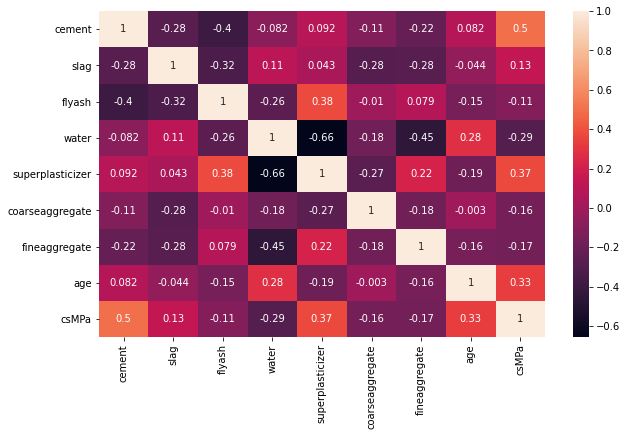

In [4]:
plt.figure(figsize = (10,6))
sns.heatmap(data.corr(),annot = True)

array([[<AxesSubplot:title={'center':'cement'}>,
        <AxesSubplot:title={'center':'slag'}>,
        <AxesSubplot:title={'center':'flyash'}>],
       [<AxesSubplot:title={'center':'water'}>,
        <AxesSubplot:title={'center':'superplasticizer'}>,
        <AxesSubplot:title={'center':'coarseaggregate'}>],
       [<AxesSubplot:title={'center':'fineaggregate'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'csMPa'}>]], dtype=object)

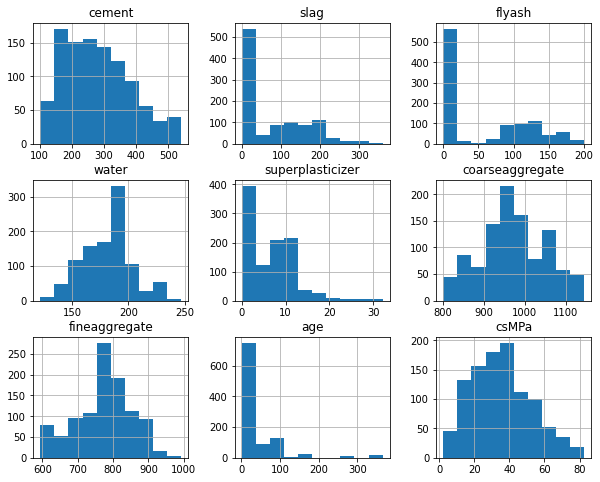

In [13]:
data.hist(figsize = (10,8))

In [21]:
data.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


## Train Test Split

In [29]:
X = data.iloc[:,:-1]
y= data.iloc[:,-1]
print(X.columns)
print(y)

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age'],
      dtype='object')
0       79.99
1       61.89
2       40.27
3       41.05
4       44.30
        ...  
1025    44.28
1026    31.18
1027    23.70
1028    32.77
1029    32.40
Name: csMPa, Length: 1030, dtype: float64


In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)

## Feature Scaling

In [33]:
sc = StandardScaler()
X_train_transformed = sc.fit_transform(X_train)
X_test_transformed = sc.transform(X_test)
X_train_transformed = pd.DataFrame(X_train_transformed, columns = X_train.columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns = X_train.columns)

## Feature Selection

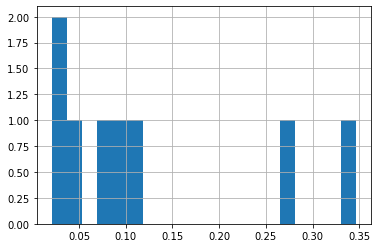

Index(['cement', 'age'], dtype='object')

In [34]:
sel = SelectFromModel(RandomForestRegressor())
sel.fit(X_train,y_train)
selected_features = X_train.columns[sel.get_support()]
pd.Series(sel.estimator_.feature_importances_.ravel()).hist(bins = 20)
plt.show()
selected_features

In [35]:
# Using SelectByShuffling from feature_engine
rf= RandomForestRegressor()
sel = SelectByShuffling(
        variables = None,
        estimator = rf,
        scoring = 'neg_root_mean_squared_error',
        cv = 3,
        random_state = 0
)
sel.fit(X_train,y_train)
sel.features_to_drop_

['slag',
 'flyash',
 'water',
 'superplasticizer',
 'coarseaggregate',
 'fineaggregate']

## Choosing a baseline model

In [59]:
lr = LinearRegression()
laso = Lasso()
rdg = Ridge()
sgd = SGDRegressor(penalty = None, eta0 = 0.000001)
elstnet = ElasticNet()
poly_reg = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 2, include_bias = False )),
    ("lin_reg", LinearRegression())
])
rf = RandomForestRegressor()
estimators = [lr,laso,rdg,sgd,elstnet,poly_reg,rf]
for estimator in estimators:
    score = cross_val_score(estimator,X_train,y_train,scoring = 'neg_root_mean_squared_error', cv = 5)
    print(estimator,score.mean(),score.std())

LinearRegression() -10.711180329793018 0.5689783919499551
Lasso() -10.713907705075226 0.5587667772265291
Ridge() -10.711176053890426 0.5689757916802436
SGDRegressor(eta0=1e-06, penalty=None) -11.414185170816591 0.6623030124976494
ElasticNet() -10.71099956582174 0.5631725163616008
Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('lin_reg', LinearRegression())]) -7.823192388351842 0.20495496453006223
RandomForestRegressor() -5.251572836585811 0.32786246497691623


## Hyperparameter Optimization

In [65]:
for deg in [2,3,5,7,10]:
    model = Pipeline([
        ("poly_features", PolynomialFeatures(degree = deg, include_bias = False )),
        ("lin_reg", LinearRegression())
    ])
    score = cross_val_score(model,X_train,y_train,scoring = 'neg_root_mean_squared_error', cv = 5)
    print(model,score.mean(),score.std())

Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('lin_reg', LinearRegression())]) -7.823192388351842 0.20495496453006223
Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lin_reg', LinearRegression())]) -6.7510380967277825 0.5067796178226717
Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('lin_reg', LinearRegression())]) -948969.225291183 728667.104352117
Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=7, include_bias=False)),
                ('lin_reg', LinearRegression())]) -88380.23646200824 151980.48433043153
Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=10, include_bias=False)),
                ('lin_reg', LinearRegression())]) -108329.3319464878 170591.55893311996


In [66]:
regressor = model = Pipeline([
        ("poly_features", PolynomialFeatures(degree = 3, include_bias = False )),
        ("lin_reg", LinearRegression())
    ])

## Evaluating model on test data

In [69]:
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
loss = mean_squared_error(y_test,y_pred)
print(loss)

51.855139115474806


Difference between R-squared and adjusted R-square:

1. Adjusted R-square can be negative only when R-square is very close to zero.

2. Adjusted R-Square values are always less than or equal to R-square but never be greater than R-Square.

3. If we add an independent variable to a model every time then, the R-squared increases, despite the independent variable being insignificant. This means that the R-square value increases when an independent variable is added despite its significance. Adjusted R-squared increases only when the independent variable is significant and affects the dependent variable.

In [73]:
R = r2_score(y_test,y_pred)
print(R)

0.7963784723469831


In [79]:
n = len(X_test)
p = len(X_test.columns)
adjusted_r2 = 1 - (1- R**2) * (n - 1)/(n - p - 1)
print(adjusted_r2)

0.6224666606544282


Text(0, 0.5, 'y_test')

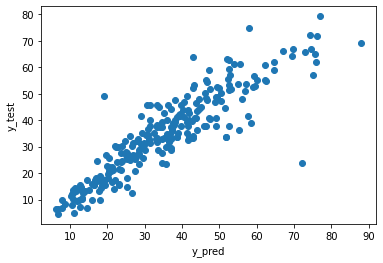

In [87]:
plt.scatter(y_pred,y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')

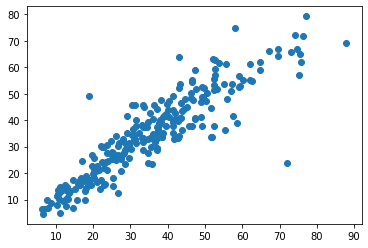